# SCENTInEL
#### sc ElasticNet transductive and inductive ensemble learning

# LR multi-tissue cross-comparison

##### Ver:: A2_V6
##### Author(s) : Issac Goh
##### Date : 220823;YYMMDD
### Author notes
    - Current defaults scrpae data from web, so leave as default and run
    - slices model and anndata to same feature shape, scales anndata object
    - added some simple benchmarking
    - creates dynamic cutoffs for probability score (x*sd of mean) in place of more memory intensive confidence scoring
    - Does not have majority voting set on as default, but module does exist
    - Multinomial logistic relies on the (not always realistic) assumption of independence of irrelevant alternatives whereas a series of binary logistic predictions does not. collinearity is assumed to be relatively low, as it becomes difficult to differentiate between the impact of several variables if this is not the case
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
### Modes to run in
    - Run in training mode
    - Run in projection mode

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl

Make sure that Python modules winreg, win32api or win32con are installed.
INFO: blas_opt_info:
INFO: blas_armpl_info:
INFO: customize UnixCCompiler
INFO:   libraries armpl_lp64_mp not found in ['/home/jovyan/my-conda-envs/scentinel_test/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blas_mkl_info:
INFO:   libraries mkl_rt not found in ['/home/jovyan/my-conda-envs/scentinel_test/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: blis_info:
INFO:   libraries blis not found in ['/home/jovyan/my-conda-envs/scentinel_test/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: openblas_info:
INFO:   libraries openblas not found in ['/home/jovyan/my-conda-envs/scentinel_test/lib', '/usr/local/lib', '/usr/lib64', '/usr/lib', '/usr/lib/x86_64-linux-gnu']
INFO:   NOT AVAILABLE
INFO: 
INFO: accelerate_info:
INF

In [2]:
models = {
    "pan_fetal_wget": "https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl",
    "YS_wget": "https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav",
}

adatas_dict = {
    "pan_fetal_wget": "https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad",
    "YS_wget": "https://app.cellatlas.io/yolk-sac/dataset/23/download",
    "FLIV_wget": "https://app.cellatlas.io/fetal-liver/dataset/1/download",
}

# Variable assignment
train_model = False
feat_use = "cell.labels"
adata_key = "FLIV_wget"  #'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local
data_merge = False  # read and merge multiple adata (useful, but keep false for now)
model_key = "pan_fetal_wget"  #'test_low_dim_ipsc_ys'# key for model of choice can be either url or local
train_x_partition = "X"  # what partition was the data trained on? To keep simple, for now only accepts 'X'
dyn_std = 1.96  # Dynamic cutoffs using std of the mean for each celltype probability, gives a column notifying user of uncertain labels 1 == 68Ci, 1.96 = 95CI
freq_redist = "cell.labels"  #'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters // not currently implemented
partial_scale = True  # should data be scaled in batches?
QC_normalise = True  # should data be normalised?

# training variables
penalty = "elasticnet"  # can be ["l1","l2","elasticnet"]
sparcity = 0.5  # C penalty for degree of regularisation
thread_num = -1
l1_ratio = 0.5  # ratio between L1 and L2 regulrisatiuon depending on penatly method

# Read in query data for projection

In [3]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler

    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    print("adata_loaded")
    import time

    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
            feat_use=feat_use,
            adata_temp=adata,
            train_x_partition=train_x_partition,
            model_key=model_key + "_lr_model",
            batch_correction="Harmony",
            var_length=7500,
            batch_key="donor",
            penalty="elasticnet",  # can be ["l1","l2","elasticnet"],
            sparcity=sparcity,  # If using LR without optimisation, this controls the sparsity in model
            max_iter=1000,  # Increase if experiencing max iter issues
            l1_ratio=l1_ratio,  # If using elasticnet without optimisation, this controls the ratio between l1 and l2)
            partial_scale=False,  # partial_scale,
            tune_hyper_params=True,  # Current implementation is very expensive, intentionally made rigid for now
        )
        filename = model_name
        pkl.dump(model_trained, open(filename, "wb"))
    finally:  #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1 - t0
        print("training complete!")
        time.sleep(3)
        print("projection time was " + str(time_s) + " seconds")
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" + "" + str(display_cpu.starting))
        print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
        print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))
    model_lr = model_trained
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    model = scent.load_models(models, model_key)
    model_lr = model

# run with usage logger
import time

t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try:  # code here ##
    pred_out, train_x, model_lr, adata_temp = scent.reference_projection(
        adata, model_lr, dyn_std, partial_scale, train_x_partition
    )
    if freq_redist != False:
        pred_out["orig_labels"] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out, "orig_labels")
        adata.obs["consensus_clus_prediction"] = pred_out["consensus_clus_prediction"]
    adata.obs["predicted"] = pred_out["predicted"]
    adata_temp.obs = adata.obs

    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally:  #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1 - t0
print("projection complete!")
time.sleep(3)
print("projection time was " + str(time_s) + " seconds")
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" + "" + str(display_cpu.starting))
print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))

Loading anndata from web source


100%|██████████| 2.60G/2.60G [00:56<00:00, 49.8MB/s]


option to apply standardisation to data detected, performing basic QC filtering
Loading model from web source


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Determining model flavour
Consuming celltypist model
LogisticRegression(max_iter=1000, multi_class='ovr', n_jobs=-1, solver='sag')
Matching reference genes in the model
🧬 6751 features used for prediction
scaling input data, default option is to use incremental learning and fit in mini bulks!
Starting reference projection!


/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scentinel/main_ML_probabillistic_methods.py:196: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'] = pred_out.loc[pred_out.max(axis=1)<(pred_out.mean(axis=1) + (1*pred_out.std(axis=1))),'confident_calls'].astype(str) + '_uncertain'


Frequency redistribution commencing
Estimating feature importance
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class
projection complete!
projection time was 298.42848229408264 seconds
Current memory usage is 1393.350532MB; Peak was 5206.515157MB
starting memory usage is0
peak CPU % usage = 180.2
peak CPU % usage/core = 6.93076923076923


In [ ]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs["predicted"].values
scent.report_f1(model_lr, train_x, train_label)

In [13]:
if train_model == True:
    scent.regression_results(
        pred_out, "orig_labels", "predicted", list(model_lr.classes_)
    )
else:
    scent.regression_results(
        pred_out, "predicted", "predicted", list(model_lr.classes_)
    )

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


Cross entropy loss:  2.2159
mean_squared_log_error:  0.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0
label Cross entropy loss: 
{'ABT(ENTRY)': 0.03529167509418392, 'B1': 0.0013089217134388878, 'CD8+T': 0.0055155892918135755, 'CYCLING_FIBROBLAST_I': 0.002106456210157371, 'CYCLING_PDC': 0.0003609917704295896, 'DC1': 0.0006850223184375502, 'DC2': 0.0014983186896910658, 'DEVELOPING_NEPHRON_I': 0.0003781269622473671, 'DN(P)_T': 0.008117433875043972, 'DN(Q)_T': 0.010125869123982403, 'DOUBLETS_FIBRO_ERY': 0.024917298786328035, 'DOUBLET_ERY_B': 0.03791152573016908, 'DOUBLET_IMMUNE_FIBROBLAST': 0.12851668874181083, 'DOUBLET_LYMPHOID_MACROPHAGE': 1.7328968444869548, 'DP(P)_T': 0.012906478699637363, 'DP(Q)_T': 0.020630534499627342, 'EARLY_ERY': 0.012802121767933538, 'EARLY_MK': 0.03996312396226314, 'ENDOTHELIUM_I': 0.0008378733607238525, 'ENDOTHELIUM_IV': 0.022984603537196467, 'ENTEROENDOCRINE_II': 0.00028627785238168464, 'EOSINOPHIL_BASOPHIL': 0.0009854947550792124, 'EPITHELIUM_I': 0.0005861573630262598, 'FI

import scentinel# View by median probabilities per classification

/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/scentinel/Visualisation.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model_mean_probs = pred_out.loc[:, pred_out.columns != 'predicted'].groupby('orig_labels').median()
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/jovyan/my-conda-envs/scentinel_test/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. T

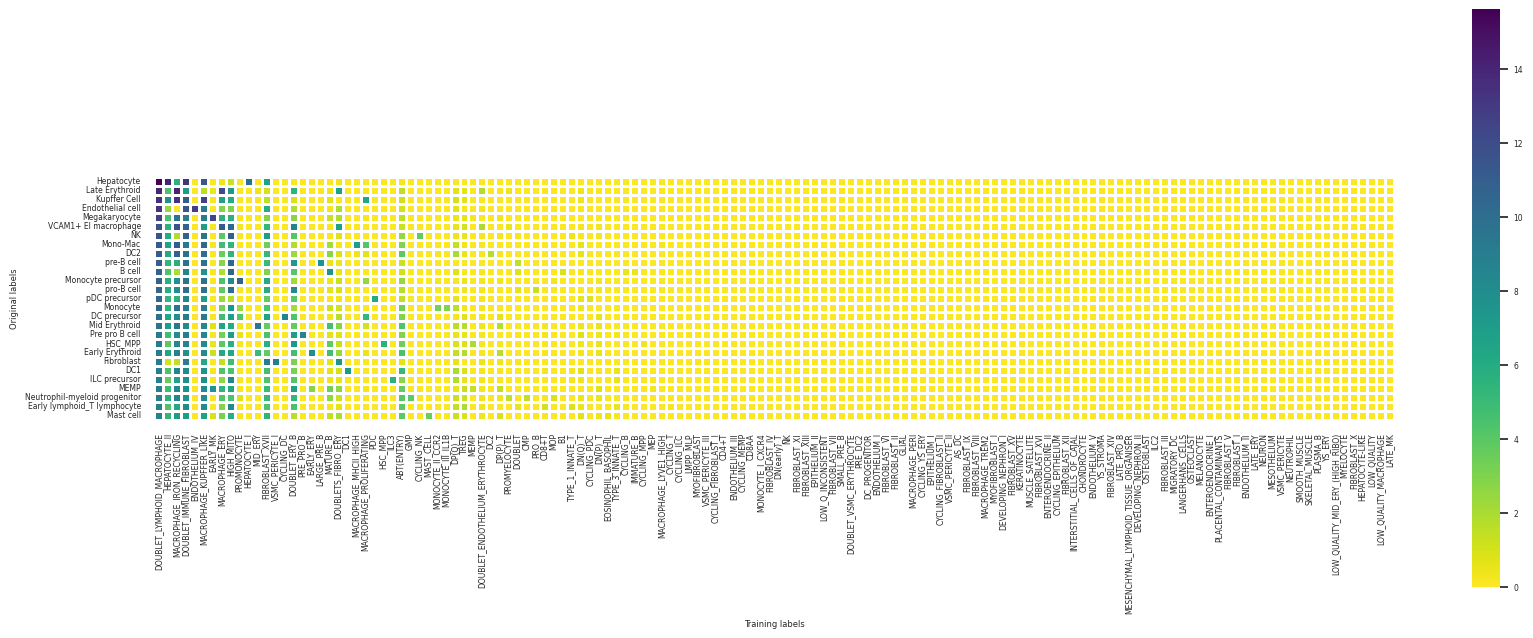

In [14]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

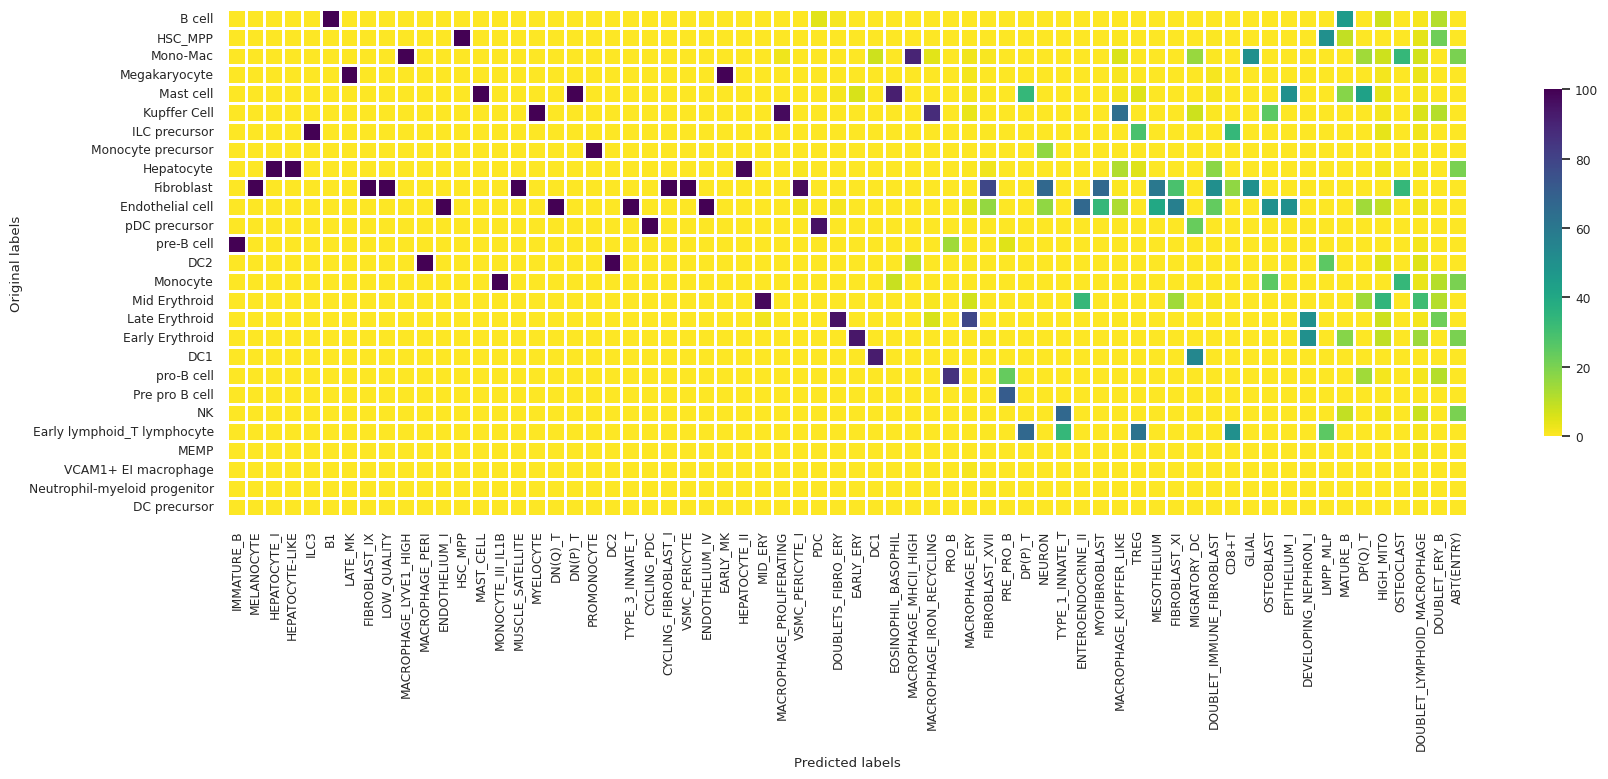

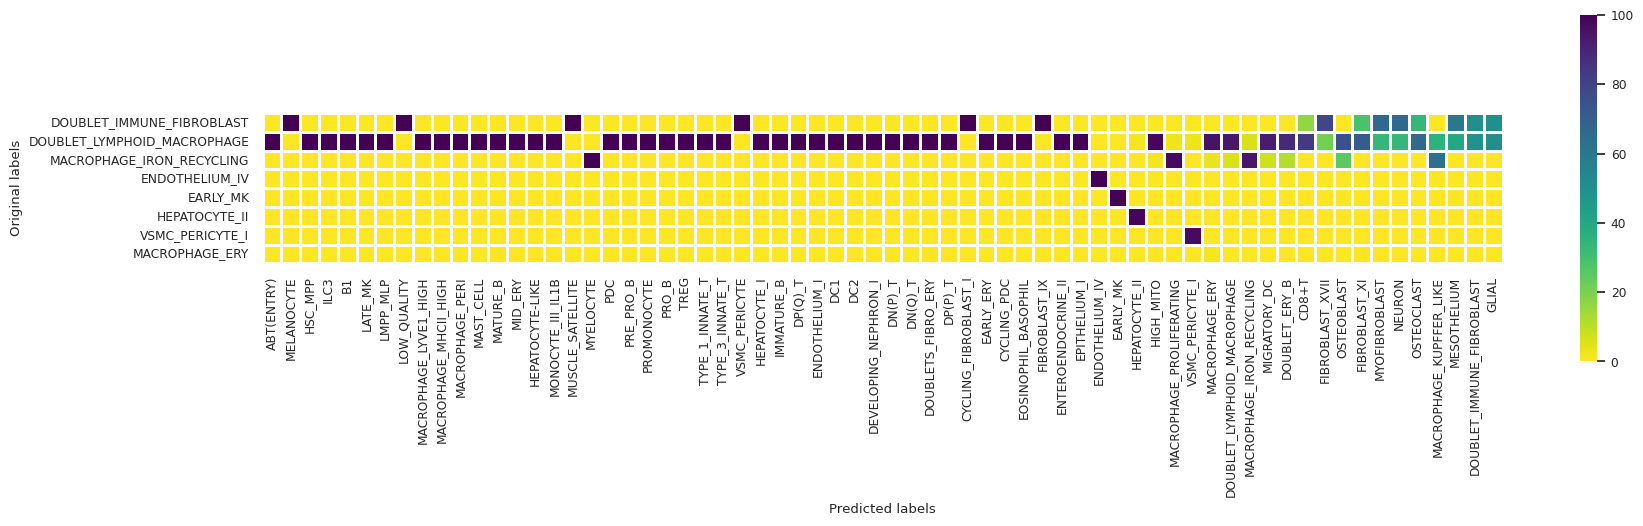

In [15]:
scent.plot_crosstab_heatmap(adata, feat_use, "predicted")
scent.plot_crosstab_heatmap(adata, "consensus_clus_prediction", "predicted")

# View top predictive features per class

In [16]:
top_loadings

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf
0,ABT(ENTRY),MALAT1,1.315743,0.274402,0.0,True
1,ABT(ENTRY),ITM2A,1.279174,0.246215,0.0,True
2,ABT(ENTRY),TFF2,1.189550,0.173575,0.000019,True
3,ABT(ENTRY),STXBP2,1.175822,0.161967,0.000912,True
4,ABT(ENTRY),AIF1,1.171449,0.158242,0.00257,True
...,...,...,...,...,...,...
13795,YS_STROMA,IGKV3-11,1.124843,0.117644,0.824449,False
13796,YS_STROMA,CRB2,1.124573,0.117404,0.83156,False
13797,YS_STROMA,ANO4,1.124341,0.117197,0.837543,False
13798,YS_STROMA,IL2,1.123533,0.116478,0.857208,False


10


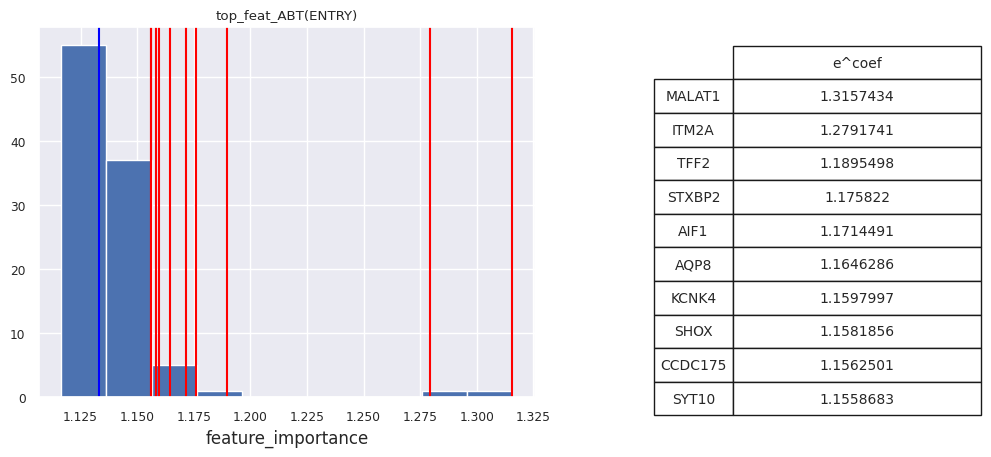

11


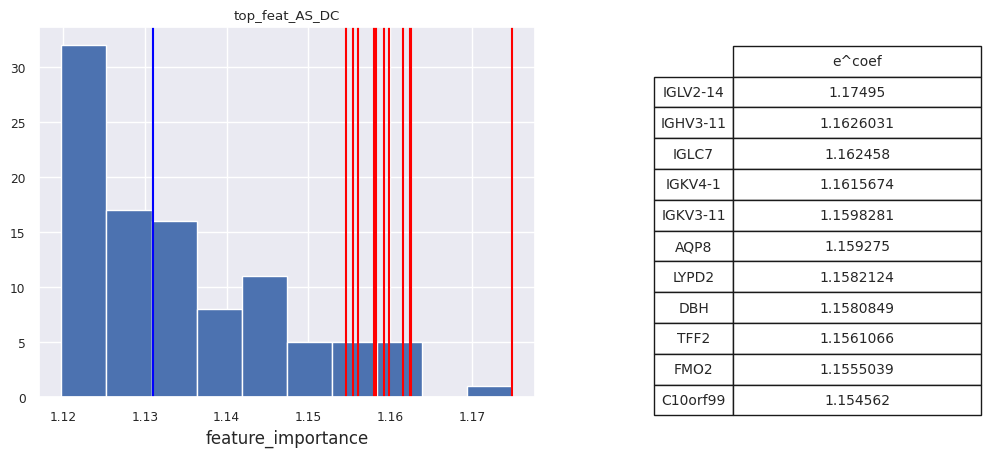

13


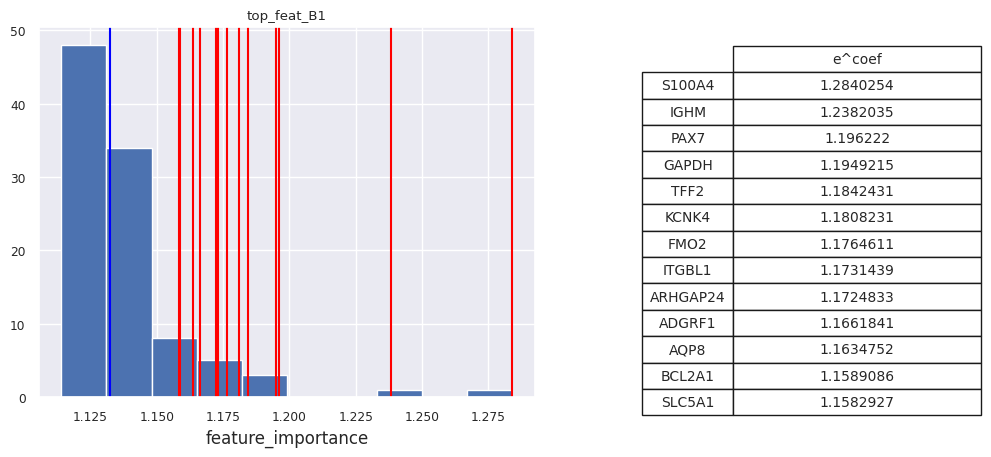

In [19]:
# Estimate dataset specific feature impact
from matplotlib import pyplot as plt

class_plot = list(model_lr.classes_)[0:3]
for classes in class_plot:  # ['pDC precursor_ys_HL','AEC_ys_HL']:
    scent.model_class_feature_plots(
        top_loadings, [str(classes)], "e^coef", "e^coef", 20, "top_feat"
    )
    plt.show()

# Save predicted output

In [ ]:
# pred_out.to_csv('./A1_V3_sk_sk_pred_outs.csv')

 # Assess feature impact on model predictions

In [22]:
top_loadings

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf
0,ABT(ENTRY),MALAT1,1.315743,0.274402,0.0,True
1,ABT(ENTRY),ITM2A,1.279174,0.246215,0.0,True
2,ABT(ENTRY),TFF2,1.189550,0.173575,0.000019,True
3,ABT(ENTRY),STXBP2,1.175822,0.161967,0.000912,True
4,ABT(ENTRY),AIF1,1.171449,0.158242,0.00257,True
...,...,...,...,...,...,...
13795,YS_STROMA,IGKV3-11,1.124843,0.117644,0.824449,False
13796,YS_STROMA,CRB2,1.124573,0.117404,0.83156,False
13797,YS_STROMA,ANO4,1.124341,0.117197,0.837543,False
13798,YS_STROMA,IL2,1.123533,0.116478,0.857208,False


10


NameError: name 'pre_ranked_enr' is not defined

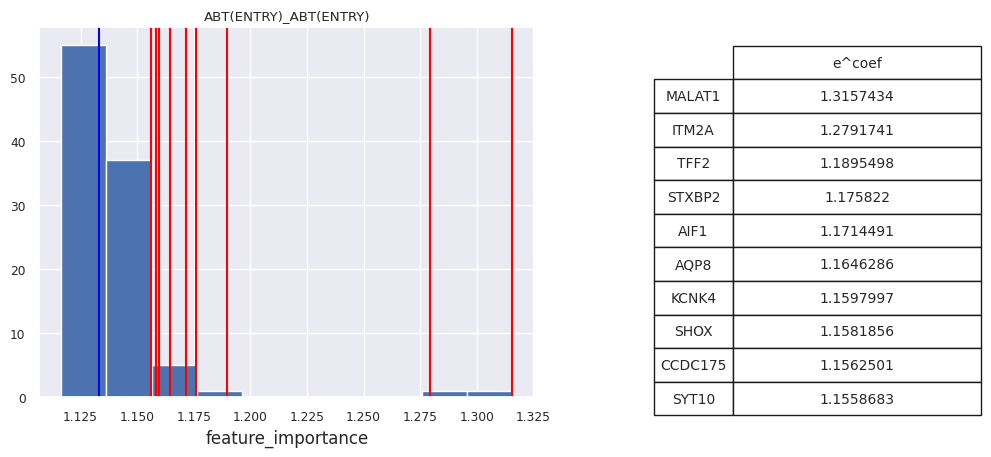

In [26]:
# if using a low-dim model like PCA or ldVAE which has a weights layer
# top_loadings = compute_weighted_impact(varm_file = '/nfs/team205/ig7/projects/fetal_skin/3_160523_probabillistic_projection_organoid_adt_fetl/A2_V2_ldvae_models/v3_ldvae_obsm_weights.csv',top_loadings =  top_loadings, threshold=0.05)

for class_lin in top_loadings["class"].unique():
    scent.model_class_feature_plots(
        top_loadings, [class_lin], "e^coef", "e^coef", max_len=20, title=class_lin
    )
    scent.analyze_and_plot_feat_gsea(
        top_loadings,
        class_lin,
        max_len=20,
        pre_ranked=True,
        database="GO_Biological_Process_2021",
        cutoff=0.25,
        min_s=5,
    )

In [27]:
list(top_loadings["class"].unique())

['ABT(ENTRY)',
 'AS_DC',
 'B1',
 'CD4+T',
 'CD8+T',
 'CD8AA',
 'CHONDROCYTE',
 'CMP',
 'CYCLING_B',
 'CYCLING_DC',
 'CYCLING_EPITHELIUM',
 'CYCLING_FIBROBLAST_I',
 'CYCLING_FIBROBLAST_II',
 'CYCLING_ILC',
 'CYCLING_MEMP',
 'CYCLING_MPP',
 'CYCLING_NK',
 'CYCLING_PDC',
 'CYCLING_T',
 'CYCLING_YS_ERY',
 'DC1',
 'DC2',
 'DC_PROGENITOR',
 'DEVELOPING_NEPHRON_I',
 'DEVELOPING_NEPHRON_II',
 'DN(P)_T',
 'DN(Q)_T',
 'DN(early)_T',
 'DOUBLET',
 'DOUBLETS_FIBRO_ERY',
 'DOUBLET_ENDOTHELIUM_ERYTHROCYTE',
 'DOUBLET_ERY_B',
 'DOUBLET_IMMUNE_FIBROBLAST',
 'DOUBLET_LYMPHOID_MACROPHAGE',
 'DOUBLET_VSMC_ERYTHROCYTE',
 'DP(P)_T',
 'DP(Q)_T',
 'EARLY_ERY',
 'EARLY_MK',
 'ENDOTHELIUM_I',
 'ENDOTHELIUM_II',
 'ENDOTHELIUM_III',
 'ENDOTHELIUM_IV',
 'ENDOTHELIUM_V',
 'ENTEROENDOCRINE_I',
 'ENTEROENDOCRINE_II',
 'EOSINOPHIL_BASOPHIL',
 'EPITHELIUM_I',
 'EPITHELIUM_II',
 'FIBROBLAST_I',
 'FIBROBLAST_II',
 'FIBROBLAST_III',
 'FIBROBLAST_IV',
 'FIBROBLAST_IX',
 'FIBROBLAST_V',
 'FIBROBLAST_VI',
 'FIBROBLAST_VII',


In [28]:
top_loadings[
    top_loadings["class"].isin(
        ["Tip cell (arterial)", "HSC", "SPP1+ proliferating neuron proneitors"]
    )
].groupby(["class"]).head(10)

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf


In [ ]:
for classes in ["Tip cell (arterial)", "HSC", "SPP1+ proliferating neuron proneitors"]:
    scent.model_class_feature_plots(top_loadings, [str(classes)], "e^coef")
    plt.show()

# Let's calculate an impact and specificty score for each cell

- We create a variable model impact factor by multiplying gene x model coeficient for class
- This is the variable contribution of each feature for a class prediction given a model and data

$X = $$\begin{bmatrix}(e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ (e^{coeff}_{n} * g1),(e^{coeff}_{n} * g2) \\ ..... \end{bmatrix}$

- We create a summed feature impact score for each cell by summing per feature ipact scores which identifies the overarching impact of a model's contribution.. == total model impact score

$Impact_{cellx} = $$\begin{bmatrix}(e^{coeff}_{n} * g1) + \ (e^{coeff}_{n} * g2) \ +(e^{coeff}_{n} * g3) \ + ..... \end{bmatrix}$

- We measure the model feature effect on class decisoion betwene organs and withi organs
- We can now use these feature availability/impact metrics to compare the availability and differential impact of features between data for transductive and/or inductive runs

In [ ]:
df_impact = scent.calculate_feature_distribution(adata, top_loadings, var="predicted")

# Label stability scoring for individual label performance

In [377]:
# pred_col shape should match the pred_out original labels, so some self-projection works best here
pred_col = list(pred_out.columns[pred_out.columns.isin(set(pred_out["orig_labels"]))])
loss, log_losses, weights = scent.compute_label_log_losses(
    pred_out, "orig_labels", pred_col
)

# Label confidence scoring, weighted probabilities and label propagation

## Bayesian KNN label stability
For modelling label uncertainty given neighborhood membership and distances

#### Step 1: Generate Binary Neighborhood Membership Matrix
The first step is to generate a binary neighborhood membership matrix from the connectivity matrix. This is done with the function get_binary_neigh_matrix(connectivities), which takes a connectivity matrix as input and outputs a binary matrix indicating whether a cell is a neighbor of another cell.

The connectivity matrix represents the neighborhood relationships between cells, typically obtained from KNN analysis. In this matrix, each row and column represent a cell, and an entry indicates the 'connectivity' between the corresponding cells.

The function transforms the connectivity matrix into a binary matrix by setting all non-zero values to 1, indicating a neighborhood relationship, and all zero values remain as 0, indicating no neighborhood relationship.

#### Step 2: Calculate Label Counts
Next, the function get_label_counts(neigh_matrix, labels) is used to count the number of occurrences of each label in the neighborhood of each cell. The input to this function is the binary neighborhood membership matrix and a list of labels for each cell.

The function returns a matrix in which each row corresponds to a cell, and each column corresponds to a label. Each entry is the count of cells of a particular label in the neighborhood of a given cell.

#### Step 3: Compute Distance-Entropy Product
In the third step, the function compute_dist_entropy_product(neigh_membership, labels, dist_matrix) computes the product of the average neighborhood distance and the entropy of the label distribution in the neighborhood for each cell and each label.

The entropy of a label distribution in a neighborhood is a measure of the diversity or 'mix' of labels in that neighborhood, with higher entropy indicating a more diverse mix of labels. The average neighborhood distance for a cell is the average distance from that cell to all other cells in its neighborhood.

By multiplying the entropy with the average distance, this function captures two important aspects of the neighborhood:

Entropy: The diversity of labels in a neighborhood. High entropy means the neighborhood is a 'melting pot' of many different labels, while low entropy indicates a neighborhood dominated by a single label.
Distance: The spatial proximity of cells in a neighborhood. A high average distance means the cells in a neighborhood are widely dispersed, while a low average distance indicates a compact, closely-knit neighborhood.
Thus, the distance-entropy product for a cell provides a measure of the 'stability' of the cell's label, with lower values indicating a stable, consistent label and higher values indicating an unstable, inconsistent label.

#### Step 4: Bayesian Sampling and Weight Calculation
The final step is the compute_weights function, which uses Bayesian inference to compute a posterior distribution of the distance-entropy product for each label and calculates the weights.

In Bayesian inference, we start with a prior distribution that represents our initial belief about the parameter we're interested in, and we update this belief using observed data to get a posterior distribution.

In this case, the prior distribution is a normal distribution with mean and standard deviation equal to the mean and standard deviation of the distance-entropy product for the original labels. The observed data is the distance-entropy product for the predicted labels. A normal distribution is a reasonable choice for the prior because the distance-entropy product is a continuous variable that can theoretically take on any real value, and the normal distribution is the most common distribution for such variables.

After sampling from the posterior distribution, the weight for each label is calculated as one minus the ratio of the standard deviation of the posterior distribution to the maximum standard deviation across all labels. This means that labels with a larger standard deviation (indicating greater uncertainty about their stability) will have smaller weights, and labels with a smaller standard deviation (indicating less uncertainty) will have larger weights.

The weights are returned as a dictionary where each key-value pair corresponds to a label and its weight.

#### Step 5: Apply Weights to Probabilities
Finally, the weights are applied to the probability dataframe with the function apply_weights(prob_df, weights). The input to this function is a dataframe where each row corresponds to a cell and each column corresponds to a label, with each entry being the probability of the cell being of the label, and a dictionary of weights.

This function multiplies each column of the probability dataframe by the corresponding weight, effectively 'boosting' the probabilities of labels with larger weights and 'penalizing' the probabilities of labels with smaller weights. After applying the weights, the function normalizes the probabilities so that they sum to 1 for each cell, returning a dataframe of the same shape as the input but with the probabilities weighted and normalized.

Overall, this method provides a principled way to quantify label uncertainty and adjust the probabilities output by a logistic regression model accordingly. It combines the strengths of KNN, which can capture local structure and relationships in the data, and Bayesian inference, which provides a robust framework for dealing with uncertainty and incorporating prior knowledge. By weighting the probabilities according to the stability of the labels, this method can potentially improve the accuracy and interpretability of the logistic regression model's predictions.

In [ ]:
weights = scent.compute_weights(
    adata,
    use_rep="neighbors",
    original_labels_col="cell.labels",
    predicted_labels_col="cell.labels",
)
adata.obsm["pred_out"] = pred_out
adata.obsm["pred_out_weighted"] = apply_weights(adata.obsm["pred_out"], weights)

# Optionally now use the updated probabilities for label propagation 

In [403]:
# Here define new labels with the updated probabilities
# Run Freq-redist or 68CI redist amongst neighborhoods or new clusters